## Disease Data 

**这一步需要对新纳入分析的疾病都做**

must have at most three cols:

eid, xxx_event, xxx_date 


如果需要区分入组前还是入组后则需要运行完全部

依赖：

1. disease df 

(opt):
1. basic df：包含recuit_date and death_date；来区分incident和生存时间（生存时间可以用于后续分析）

In [2]:
import pandas as pd

import statsmodels.api as sm
import pandas as pd
import datetime
from pathlib import Path

pd.set_option("display.max_columns", None)
# !pip install statsmodels


%config InlineBackend.figure_format = "svg"
%config InlineBackend.print_figure_kwargs = {"dpi" : 300}
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# from cadFace.vis import percentiles_plot
import sci_palettes

try:
    sci_palettes.register_cmap()
except:
    pass
import scienceplots
from pathlib import Path
import pandas as pd


plt.style.use(["nature", "no-latex"])
sns.set_context("paper", font_scale=1.5)
sns.set_palette("nejm")

In [3]:
def load_data(x):
    if ".csv" in x:
        return pd.read_csv(x)
    elif x.endswith(".feather"):
        return pd.read_feather(x)
    elif x.endswith(".pkl"):
        return pd.read_pickle(x)
    elif ".tsv" in x:
        return pd.read_csv(x, sep="\t")
    else:
        raise ValueError(f"File format: {x} not supported")

In [4]:
## 检查数据分布情况

rootDir = Path("MulitOmicsDisease/")
traindataDir = rootDir / "traindata/"


disease_path = (
    "/home/xutingfeng/ukb/ukbData/phenotypes/ukb_ph/disease_extracted/CAD_v3.tsv"
)
disease_name = Path(disease_path).stem

disease_df = load_data(disease_path)
disease_df = disease_df.dropna(subset=[disease_df.columns[1]])
disease_df

,eid,event,date
0,1000017,1.0,2020-10-19
1,1000025,1.0,1995-10-28
2,1000038,0.0,NaN
3,1000042,1.0,2010-12-12
4,1000056,0.0,NaN
...,...,...,...
502404,6024086,0.0,NaN
502405,6024098,0.0,NaN
502406,6024103,0.0,NaN
502407,6024110,0.0,NaN


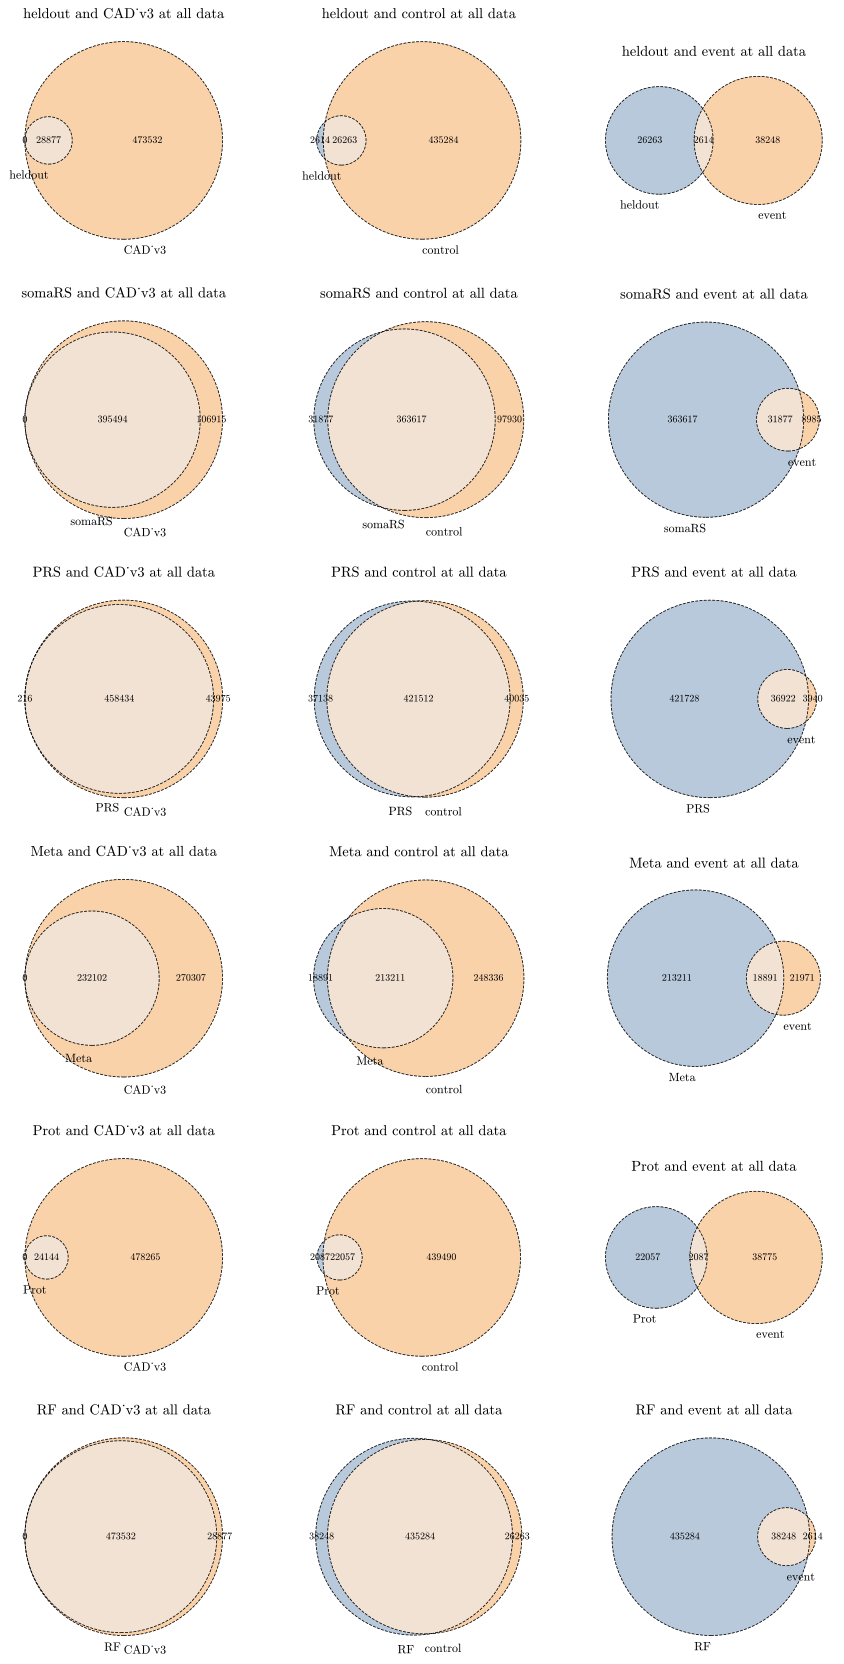

In [5]:
# plot venn of disease and omics data
from matplotlib_venn import venn2, venn2_circles
import math

training_data_path = list(traindataDir.glob("*.feather"))
columns = 3
row = len(training_data_path)


fig, axes = plt.subplots(row, columns, figsize=(columns * 5, row * 5))


for idx in range(len(training_data_path)):
    ax1 = axes[idx, 0]
    ax2 = axes[idx, 1]
    ax3 = axes[idx, 2]

    path = training_data_path[idx]
    name = path.stem

    data = pd.read_feather(path)[["eid"]]

    event_eids = set(disease_df[disease_df.iloc[:, 1] == 1]["eid"])
    control_eids = set(disease_df[disease_df.iloc[:, 1] == 0]["eid"])
    disease_eids = set(disease_df.eid)
    data_eids = set(data.eid)

    # ax1 draw all cross data

    g = venn2(
        [data_eids, disease_eids],
        (name, disease_name),
        set_colors=("#4e79a7", "#f28e2b"),
        ax=ax1,
    )
    g = venn2_circles(
        subsets=[data_eids, disease_eids],
        linestyle="--",
        linewidth=0.8,
        color="black",  # 外框线型、线宽、颜色
        ax=ax1,
    )
    ax1.set_title(f"{name} and {disease_name} at all data")

    # ax2 draw control cross data
    g = venn2(
        [data_eids, control_eids],
        (name, "control"),
        set_colors=("#4e79a7", "#f28e2b"),
        ax=ax2,
    )
    g = venn2_circles(
        subsets=[data_eids, control_eids],
        linestyle="--",
        linewidth=0.8,
        color="black",  # 外框线型、线宽、颜色
        ax=ax2,
    )

    ax2.set_title(f"{name} and control at all data")

    # ax3 draw event cross data
    g = venn2(
        [data_eids, event_eids],
        (name, "event"),
        set_colors=("#4e79a7", "#f28e2b"),
        ax=ax3,
    )
    g = venn2_circles(
        subsets=[data_eids, event_eids],
        linestyle="--",
        linewidth=0.8,
        color="black",  # 外框线型、线宽、颜色
        ax=ax3,
    )
    ax3.set_title(f"{name} and event at all data")

### incident 区分

对于部分疾病需要进一步区分清楚incident还是Prevalent：

需要疾病有date

即disease_df 必须有三列：eid, event, date

In [6]:
import datetime

event_col = disease_df.columns[1]
event_date_col = disease_df.columns[2] if len(disease_df.columns) > 2 else None

if event_date_col:
    disease_df[event_date_col] = pd.to_datetime(disease_df[event_date_col])
else:

    raise ValueError("no date column")

进一步整合recuit_date (coding 53) and death_date (coding 40000)

In [7]:
# note this need date of assesment at coding 53
# death 40000

basic_info = pd.read_feather(
    "/home/xutingfeng/ukb/ukbData/phenotypes/ukb_ph/basic_info.feather"
)[["eid", "recuit_date", "death_date"]]
basic_info

,eid,recuit_date,death_date
0,1000017,2010-07-10,NaT
1,1000025,2010-06-12,NaT
2,1000038,2008-03-29,NaT
3,1000042,2008-06-12,NaT
4,1000056,2009-07-13,NaT
...,...,...,...
502239,6024086,2009-05-05,2021-10-12
502240,6024098,2010-02-03,NaT
502241,6024103,2008-02-07,NaT
502242,6024110,2009-10-28,NaT


In [8]:
disease_df = pd.merge(disease_df, basic_info, on="eid", how="left")
disease_df

,eid,event,date,recuit_date,death_date
0,1000017,1.0,2020-10-19,2010-07-10,NaT
1,1000025,1.0,1995-10-28,2010-06-12,NaT
2,1000038,0.0,NaT,2008-03-29,NaT
3,1000042,1.0,2010-12-12,2008-06-12,NaT
4,1000056,0.0,NaT,2009-07-13,NaT
...,...,...,...,...,...
502404,6024086,0.0,NaT,2009-05-05,2021-10-12
502405,6024098,0.0,NaT,2010-02-03,NaT
502406,6024103,0.0,NaT,2008-02-07,NaT
502407,6024110,0.0,NaT,2009-10-28,NaT


In [9]:
assert (
    disease_df[event_col].isna().sum() == 0
), "event column has nan value, please check NA value and fillna or dropna"

In [10]:
event_df = disease_df[disease_df[event_col] == 1]
incident_df = event_df[event_df[event_date_col] > event_df.recuit_date]
prevalent_df = event_df[~event_df.index.isin(incident_df.index)]
control_df = disease_df[disease_df[event_col] == 0]

incident_disease_df = pd.concat([incident_df, control_df]).reset_index(drop=True)
prevalent_disease_df = pd.concat([prevalent_df, control_df]).reset_index(drop=True)
print(f"incident disease: {len(incident_df)}")
print(f"prevalent disease: {len(prevalent_df)}")
print(f"control: {len(control_df)}")

incident disease: 23345
prevalent disease: 17517
control: 461547


定义生存时间

In [11]:
def getSurvTime(
    data,
    event_col,
    event_date_col,
    recuit_date_col,
    death_date_col,
    rightcensor_date=datetime.datetime(2024, 1, 1),
):
    data = data[[event_col, event_date_col, recuit_date_col, death_date_col]].copy()

    data[event_date_col] = pd.to_datetime(data[event_date_col])
    data[recuit_date_col] = pd.to_datetime(data[recuit_date_col])
    data[death_date_col] = pd.to_datetime(data[death_date_col])

    def getSurvTimeFunc(x):
        event_date = x[event_date_col]
        recuit_date = x[recuit_date_col]
        death_date = x[death_date_col]

        if pd.isnull(event_date) and pd.isnull(
            death_date
        ):  # right censor - recuit; No death or event happend
            return rightcensor_date - recuit_date
        elif pd.isnull(event_date) and pd.notnull(
            death_date
        ):  # death - recuit; death happend and no event
            return death_date - recuit_date
        elif pd.notnull(event_date) and pd.isnull(
            death_date
        ):  # event - recuit; event happend and no death
            return event_date - recuit_date
        else:  # event and death
            return event_date - recuit_date

    # data.loc[:, "survTime"] = data.apply(getSurvTimeFunc, axis=1).dt.days / 365
    return data.apply(getSurvTimeFunc, axis=1).dt.days / 365

In [12]:
incident_disease_df["survTime"] = getSurvTime(
    incident_disease_df,
    event_col=incident_disease_df.columns[1],
    event_date_col=incident_disease_df.columns[2],
    recuit_date_col="recuit_date",
    death_date_col="death_date",
)
incident_disease_df

,eid,event,date,recuit_date,death_date,survTime
0,1000017,1.0,2020-10-19,2010-07-10,NaT,10.284932
1,1000042,1.0,2010-12-12,2008-06-12,NaT,2.501370
2,1000512,1.0,2011-03-14,2007-09-07,NaT,3.517808
3,1000711,1.0,2020-08-09,2009-07-03,2020-08-09,11.109589
4,1000797,1.0,2016-01-23,2008-03-11,NaT,7.873973
...,...,...,...,...,...,...
484887,6024086,0.0,NaT,2009-05-05,2021-10-12,12.446575
484888,6024098,0.0,NaT,2010-02-03,NaT,13.917808
484889,6024103,0.0,NaT,2008-02-07,NaT,15.909589
484890,6024110,0.0,NaT,2009-10-28,NaT,14.186301


绘制incident和prevalent与omics data 的venn plot

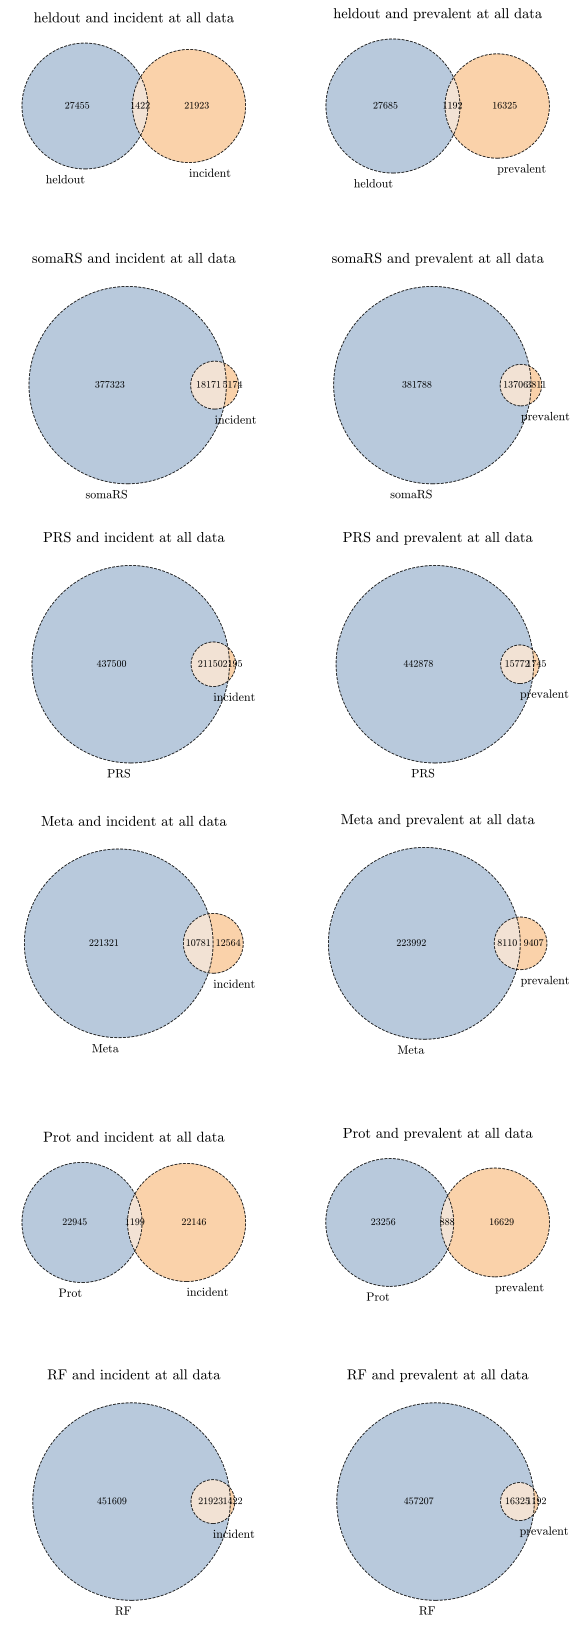

In [13]:
from matplotlib_venn import venn2, venn2_circles
import math

training_data_path = list(traindataDir.glob("*.feather"))
columns = 2
row = len(training_data_path)


fig, axes = plt.subplots(row, columns, figsize=(columns * 5, row * 5))


for idx in range(len(training_data_path)):
    ax1 = axes[idx, 0]
    ax2 = axes[idx, 1]

    path = training_data_path[idx]
    name = path.stem

    data = pd.read_feather(path)[["eid"]]

    incident_eids = set(incident_df.eid)
    prevalent_eids = set(prevalent_df.eid)

    data_eids = set(data.eid)

    # ax1 plot incident in each
    g = venn2(
        [data_eids, incident_eids],
        (name, "incident"),
        set_colors=("#4e79a7", "#f28e2b"),
        ax=ax1,
    )
    g = venn2_circles(
        subsets=[data_eids, incident_eids],
        linestyle="--",
        linewidth=0.8,
        color="black",  # 外框线型、线宽、颜色
        ax=ax1,
    )

    ax1.set_title(f"{name} and incident at all data")
    # ax2 plot prevalent in each
    g = venn2(
        [data_eids, prevalent_eids],
        (name, "prevalent"),
        set_colors=("#4e79a7", "#f28e2b"),
        ax=ax2,
    )
    g = venn2_circles(
        subsets=[data_eids, prevalent_eids],
        linestyle="--",
        linewidth=0.8,
        color="black",  # 外框线型、线宽、颜色
        ax=ax2,
    )
    ax2.set_title(f"{name} and prevalent at all data")

In [14]:
disease_df = incident_disease_df[["eid", event_col, event_date_col, "survTime"]]

In [15]:
disease_df

,eid,event,date,survTime
0,1000017,1.0,2020-10-19,10.284932
1,1000042,1.0,2010-12-12,2.501370
2,1000512,1.0,2011-03-14,3.517808
3,1000711,1.0,2020-08-09,11.109589
4,1000797,1.0,2016-01-23,7.873973
...,...,...,...,...
484887,6024086,0.0,NaT,12.446575
484888,6024098,0.0,NaT,13.917808
484889,6024103,0.0,NaT,15.909589
484890,6024110,0.0,NaT,14.186301


### save 

In [16]:
disease_df_saveDir = rootDir / "disease"
disease_df_saveDir.mkdir(exist_ok=True, parents=True)
disease_df.to_feather(disease_df_saveDir / f"{disease_name}.feather")